# Metodo della GHT

Usato per produrre schemi, figure e tabelle per la relazione

Immagine originale: (375, 500, 3)
Immagine normalizzata: (500, 500, 3)
Grayscale: (500, 500)


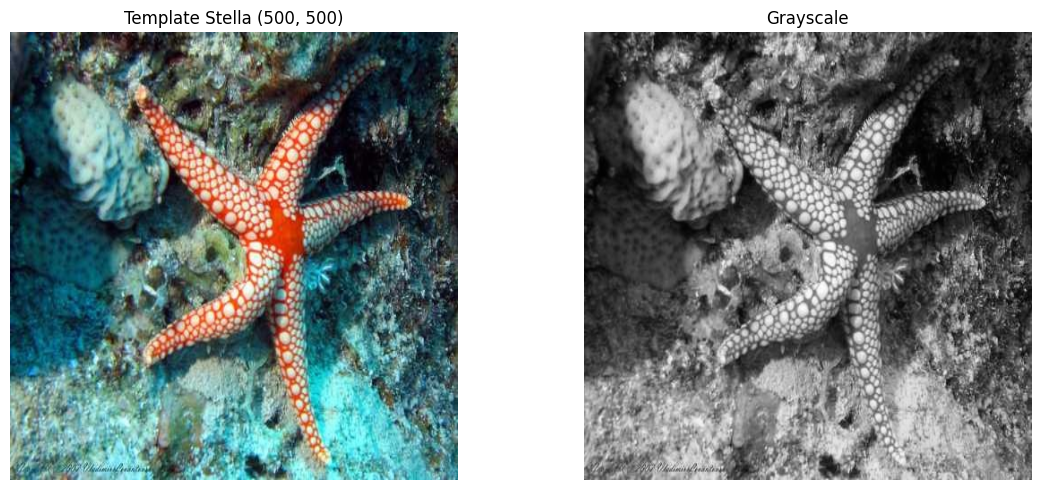

In [5]:
# Carica template e preprocessa
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import ght

# Migliore template per ora "a occhio" (dimensioni, colori, texture)
TEMPLATE="data/hough/00022_r_any_other_kind_of_starfish_169.jpg"

# 1. Carica template
stella = cv2.imread(TEMPLATE)
print(f"Immagine originale: {stella.shape}")

# Normalizza dimensioni
stella_resized = cv2.resize(stella, ght.STANDARD_SIZE)
print(f"Immagine normalizzata: {stella_resized.shape}")

# 2. Converti in scala di grigi
stella_gray = cv2.cvtColor(stella_resized, cv2.COLOR_BGR2GRAY)
print(f"Grayscale: {stella_gray.shape}")

# Visualizza
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(cv2.cvtColor(stella_resized, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Template Stella {ght.STANDARD_SIZE}')
axes[0].axis('off')
axes[1].imshow(stella_gray, cmap='gray')
axes[1].set_title('Grayscale')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Gradiente in P: grad_x=-62.00, grad_y=-110.00
phi = arctan2(-110.00, -62.00) = -2.084 rad = 240.6°
  -> phi è l'orientazione del gradiente (perpendicolare al bordo)

Vettore P→C: r_x=-119, r_y=256
alpha = arctan2(256, -119) = 2.006 rad = 114.9°
  -> alpha è l'angolo del vettore da P verso C


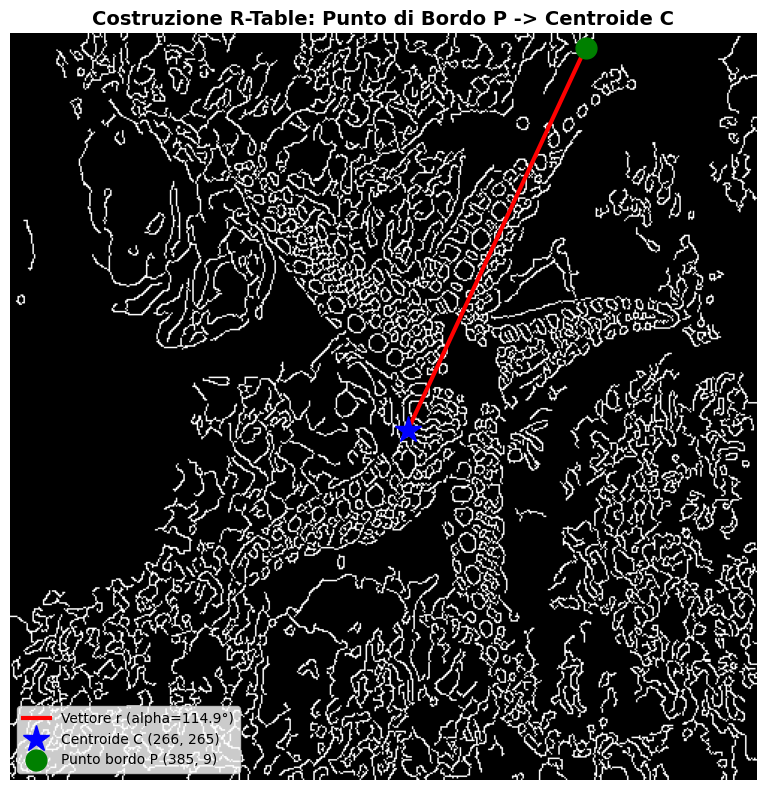

phi_i = 240.6° (orientazione GRADIENTE perpendicolare al bordo)
r = 282.3 pixel (distanza da P a C)
alpha = 114.9° (angolo del vettore P→C)
Vettore r = (-119, 256)

R-TABLE ENTRY:
R-table[phi_i=240.6°] = [(r=282.3, α=114.9°)]


In [14]:
# 1. Rilevamento bordi con Canny
gray_blurred = cv2.GaussianBlur(stella_gray, (5, 5), 1.4)
stella_edges = cv2.Canny(gray_blurred, 50, 150)

# 2. Calcola il centroide C (baricentro dei punti di bordo)
edge_points = np.column_stack(np.where(stella_edges > 0))
center_y, center_x = np.mean(edge_points, axis=0).astype(int)
C = (center_x, center_y)

# 3. Seleziona un punto di bordo P di esempio
P_y, P_x = edge_points[500]  # Prendiamo un punto di esempio
P = (P_x, P_y)

# 4. Calcola i gradienti per trovare phi (orientazione del gradiente in P)
# IMPORTANTE: phi è l'angolo del GRADIENTE (perpendicolare al bordo), non l'angolo P→C
grad_x = cv2.Sobel(gray_blurred, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray_blurred, cv2.CV_64F, 0, 1, ksize=3)

# arctan2(grad_y, grad_x) calcola l'angolo del vettore gradiente
# Il gradiente punta nella direzione di massima variazione di intensità (perpendicolare al bordo)
phi = np.arctan2(grad_y[P_y, P_x], grad_x[P_y, P_x])
phi_deg = np.degrees(phi) % 360

print(f"Gradiente in P: grad_x={grad_x[P_y, P_x]:.2f}, grad_y={grad_y[P_y, P_x]:.2f}")
print(f"phi = arctan2({grad_y[P_y, P_x]:.2f}, {grad_x[P_y, P_x]:.2f}) = {phi:.3f} rad = {phi_deg:.1f}°")
print(f"  -> phi è l'orientazione del gradiente (perpendicolare al bordo)")

# 5. Calcola il vettore r da P a C
r_x = C[0] - P[0]
r_y = C[1] - P[1]
r_magnitude = np.sqrt(r_x**2 + r_y**2)
alpha = np.arctan2(r_y, r_x)
alpha_deg = np.degrees(alpha) % 360

print(f"\nVettore P→C: r_x={r_x}, r_y={r_y}")
print(f"alpha = arctan2({r_y}, {r_x}) = {alpha:.3f} rad = {alpha_deg:.1f}°")
print(f"  -> alpha è l'angolo del vettore da P verso C")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# Mostra l'immagine dopo Canny (bordi)
ax.imshow(stella_edges, cmap='gray')

# Disegna la linea da P a C in rosso solido
ax.plot([P[0], C[0]], [P[1], C[1]], 'r-', linewidth=3, label=f'Vettore r (alpha={alpha_deg:.1f}°)')

# Disegna i punti
ax.plot(C[0], C[1], 'b*', markersize=20, label=f'Centroide C {C}')
ax.plot(P[0], P[1], 'go', markersize=15, label=f'Punto bordo P {P}')

ax.set_title('Costruzione R-Table: Punto di Bordo P -> Centroide C', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"phi_i = {phi_deg:.1f}° (orientazione GRADIENTE perpendicolare al bordo)")
print(f"r = {r_magnitude:.1f} pixel (distanza da P a C)")
print(f"alpha = {alpha_deg:.1f}° (angolo del vettore P→C)")
print(f"Vettore r = ({r_x}, {r_y})")
print(f"\nR-TABLE ENTRY:")
print(f"R-table[phi_i={phi_deg:.1f}°] = [(r={r_magnitude:.1f}, α={alpha_deg:.1f}°)]")


STEP 1: Costruzione R-Table dal template
R-table costruita con 36 bin
Punti di bordo nel template: 35115

STEP 2: Carica immagine test
Test image: data/hough/00002_r_any_other_kind_of_starfish_148.jpg

STEP 3: Rilevamento bordi
Punti di bordo rilevati: 11001

STEP 4: Inizializza accumulatore A[xmax][ymax] = 0

STEP 5: Processo di voting
Voting completato
Voto massimo nell'accumulatore: 101

STEP 6: Trova massimo locale
Centro rilevato: (244, 321)
Numero di voti: 101


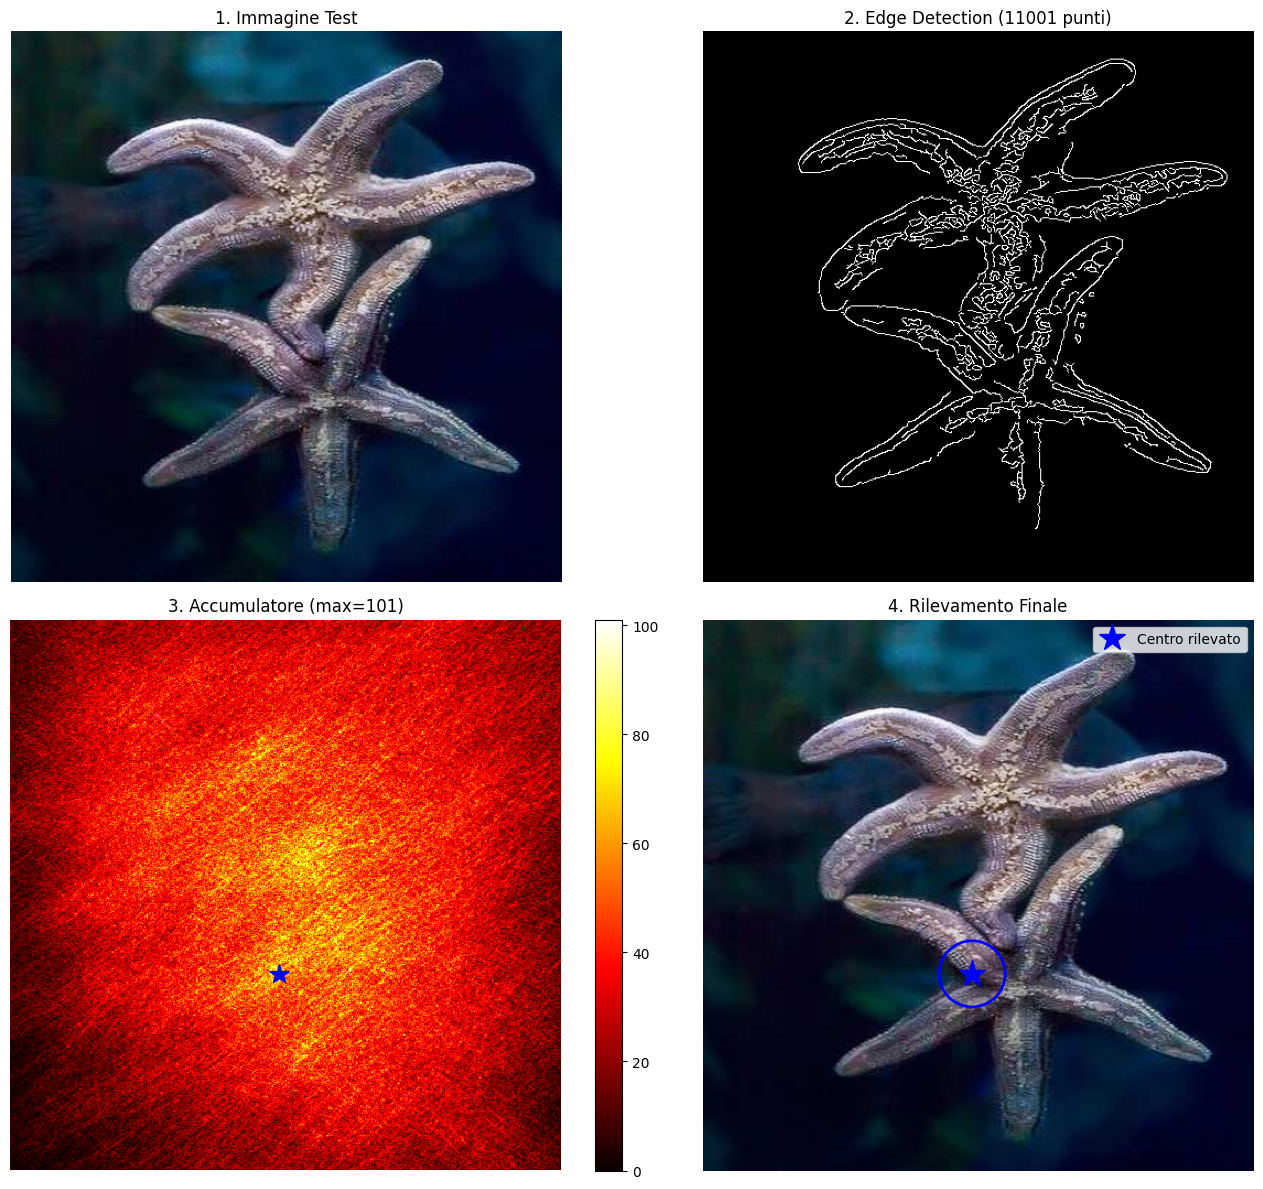

In [ ]:
# STEP 1: Costruisci R-Table dal template
print("STEP 1: Costruzione R-Table dal template")

# Quantizza gli angoli in bin (36 bin = 10 gradi ciascuno)
angle_bins = 36
bin_size = 360 / angle_bins

# Inizializza R-table come dizionario
R_table = {i: [] for i in range(angle_bins)}

# Calcola gradienti per il template
grad_x_template = cv2.Sobel(gray_blurred, cv2.CV_64F, 1, 0, ksize=3)
grad_y_template = cv2.Sobel(gray_blurred, cv2.CV_64F, 0, 1, ksize=3)

# Per ogni punto di bordo nel template
for point in edge_points:
    y, x = point
    
    # Calcola phi (orientazione gradiente)
    phi = np.arctan2(grad_y_template[y, x], grad_x_template[y, x])
    phi_deg = np.degrees(phi) % 360
    bin_idx = int(phi_deg / bin_size)
    
    # Calcola vettore da punto a centroide
    r_x = C[0] - x
    r_y = C[1] - y
    r = np.sqrt(r_x**2 + r_y**2)
    alpha = np.arctan2(r_y, r_x)
    
    # Aggiungi alla R-table
    R_table[bin_idx].append((r, alpha))

print(f"R-table costruita con {angle_bins} bin")
print(f"Punti di bordo nel template: {len(edge_points)}")

# STEP 2: Carica immagine test random
print("\nSTEP 2: Carica immagine test")
import glob
import random

test_images = glob.glob("data/hough/*starfish*.jpg")
test_images = [f for f in test_images if f != TEMPLATE]
random.seed(42)
test_path = random.choice(test_images)
print(f"Test image: {test_path}")

test_img = cv2.imread(test_path)
test_img = cv2.resize(test_img, ght.STANDARD_SIZE)
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# STEP 3: Rileva bordi nell'immagine test
print("\nSTEP 3: Rilevamento bordi")
test_blurred = cv2.GaussianBlur(test_gray, (5, 5), 1.4)
test_edges = cv2.Canny(test_blurred, 50, 150)
test_edge_points = np.column_stack(np.where(test_edges > 0))
print(f"Punti di bordo rilevati: {len(test_edge_points)}")

# STEP 4: Inizializza accumulatore
print("\nSTEP 4: Inizializza accumulatore A[xmax][ymax] = 0")
h, w = test_gray.shape
accumulator = np.zeros((h, w), dtype=np.int32)
print(f"Dimensioni accumulatore: {h}x{w}")
print(f"Ogni cella conta quanti voti riceve quella posizione come possibile centro")

# STEP 5: Voting process
print("\nSTEP 5: Processo di voting")
grad_x_test = cv2.Sobel(test_blurred, cv2.CV_64F, 1, 0, ksize=3)
grad_y_test = cv2.Sobel(test_blurred, cv2.CV_64F, 0, 1, ksize=3)

for point in test_edge_points:
    yI, xI = point
    
    # Calcola phi per questo punto
    phi = np.arctan2(grad_y_test[yI, xI], grad_x_test[yI, xI])
    phi_deg = np.degrees(phi) % 360
    bin_idx = int(phi_deg / bin_size)
    
    # Accedi alla R-table
    for (r, alpha) in R_table[bin_idx]:
        # Calcola possibile posizione del centroide
        xc = int(xI + r * np.cos(alpha))
        yc = int(yI + r * np.sin(alpha))
        
        # Incrementa accumulatore se dentro i limiti
        if 0 <= xc < w and 0 <= yc < h:
            accumulator[yc, xc] += 1

print(f"Voting completato")
print(f"Voto massimo nell'accumulatore: {accumulator.max()}")
print(f"Celle con almeno 1 voto: {np.count_nonzero(accumulator)}")

# STEP 6: Trova massimo locale
print("\nSTEP 6: Trova massimo locale")
max_val = accumulator.max()
# Trova la posizione del massimo
flat_idx = accumulator.argmax()  # Indice "appiattito" (1D)
detected_y = flat_idx // w  # Riga (y)
detected_x = flat_idx % w   # Colonna (x)
print(f"Centro rilevato: ({detected_x}, {detected_y})")
print(f"Numero di voti: {max_val}")

# VISUALIZZAZIONE: 4 pannelli
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel 1: Immagine originale test
axes[0, 0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('1. Immagine Test')
axes[0, 0].axis('off')

# Panel 2: Edge detection
axes[0, 1].imshow(test_edges, cmap='gray')
axes[0, 1].set_title(f'2. Edge Detection ({len(test_edge_points)} punti)')
axes[0, 1].axis('off')

# Panel 3: Accumulatore come heatmap
# L'accumulatore e' una matrice HxW dove ogni cella contiene il numero di voti
# imshow visualizza questa matrice come immagine: valore alto = colore piu' chiaro/caldo
# cmap='hot': nero=0 voti, rosso=pochi, giallo=medio, bianco=molti voti
im = axes[1, 0].imshow(accumulator, cmap='hot', interpolation='nearest')
axes[1, 0].plot(detected_x, detected_y, 'b*', markersize=15)
axes[1, 0].set_title(f'3. Accumulatore (max={max_val} voti)')
axes[1, 0].axis('off')
# La colorbar mostra la scala: da 0 (nero) al massimo (bianco/giallo)
plt.colorbar(im, ax=axes[1, 0], fraction=0.046, label='Numero voti')

# Panel 4: Risultato finale
axes[1, 1].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
axes[1, 1].plot(detected_x, detected_y, 'b*', markersize=20, label='Centro rilevato')
circle = plt.Circle((detected_x, detected_y), 30, color='blue', fill=False, linewidth=2)
axes[1, 1].add_patch(circle)
axes[1, 1].set_title('4. Rilevamento Finale')
axes[1, 1].legend()
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
